# Training Models

In this notebook we train and evaluate models for predicting human moral ratings of images (based on the ratings in SMID).

Below is a code chunk that allows you to pop-out all graphs and visuals produced in this notebook. It will making viewing some graphs in this notebook significantly easier, as otherwise, the text for these graphs may not fit nicely.

Below that is another code chunk that reverts this.

In [28]:
# Run to make the plots pop out of the .ipynb file (if using vscode)
%matplotlib qt

In [44]:
# Run to make the plots stay in the .ipynb file (if using vscode)
%matplotlib inline 

## Set Up

### Basic Imports and Caption/Image Set-up

In [1]:
# Imports
from collections import Counter
import clip
import cv2
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
from PIL import Image
import re
from scipy import stats as sp
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
import string
import torch
from zipfile import ZipFile

In [2]:
# Read the csv files
norms_df = pd.read_csv("./Data/SMID_norms.csv")
# Rename columns accordingly
norms_df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
# We need to resort the IDs due to how the caption image train-test splits were done
# We wish to use the same splits, so this must be done
norms_df = norms_df.sort_values(by=['ID'])

# Get the norms matrix (for our predicted variables)
col_names = ["valence_mean", "arousal_mean", 
             "moral_mean", "authority_mean",
             "fairness_mean", "harm_mean",
             "ingroup_mean", "purity_mean"]
Y = norms_df[col_names].to_numpy()

In [3]:
zfile = ZipFile('./Data/SMID_images_400px.zip', 'r')
list_of_files = zfile.namelist()

# Get the image file extension type (.jpg, .png, or .gif)
def ID_to_extension(image_ID):
    filename = [img for img in list_of_files if image_ID+'.' in img][0]
    return filename.split(".")[-1]

# Get the numpy array for the img ID
#
# Code modified from:
# https://stackoverflow.com/questions/60919216/how-to-read-files-in-a-folder-within-a-zipped-folder-in-python
def ID_to_image(image_ID):
    # Dealing with that one converted gif image
    if image_ID=="b10_p135_4":
        img = cv2.imread("./Data/b10_p135_4.jpg") #BGR
        return img

    # Dealing with "normal" images
    ID_ext = ID_to_extension(image_ID)
    data = zfile.read('img/'+image_ID+'.'+ID_ext)
    # Our code can't handle gifs, so we double check here.
    if ID_ext in ['jpg', 'jpeg', 'png']:
        # Decode bytes to image.
        img = cv2.imdecode(np.fromstring(data, np.uint8), cv2.IMREAD_COLOR) #BGR
        return img 
    return None

def image_to_PIL(img):
    if len(img.shape)==3 and img.shape[2]==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    return Image.fromarray(img)

def color_to_grayscale(img_bgr):
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

# Display the image until a key is pressed
def display_image(img, id='img'):
    cv2.imshow(id, img)
    cv2.waitKey(0) # Wait until a key is pressed
    cv2.destroyAllWindows() 

In [4]:
def kfoldRidgeCV(X,y,k,alpha):
    # define model
    model = Ridge(alpha=alpha)
    # define model evaluation method
    cv = RepeatedKFold(n_splits=k, n_repeats=3, random_state=365)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    # force scores to be positive
    return np.mean(abs(scores))

In [5]:
# Google Captions

# Get the Vertex IDs and make a mask
with open('./Data/SMIDVertex.pickle', 'rb') as handle:
    Vertex_dict = pickle.load(handle)
Vertex_df = pd.DataFrame({'ID':Vertex_dict.keys(), 'caption':Vertex_dict.values()})
Vertex_df = Vertex_df.drop(Vertex_df[Vertex_df['caption'].str.len()==0].index)
Vertex_df = Vertex_df.sort_values(by=['ID'])
Vertex_df['ID']=Vertex_df['ID'].str.split('.')
Vertex_df['ID']=Vertex_df['ID'].str[0]
Vertex_df['caption']=Vertex_df['caption'].str[0]
# Get the Vertex IDs and make a mask
Vertex_IDs = list(Vertex_df['ID'])
subset_mask = norms_df['ID'].isin(Vertex_IDs)

In [6]:
# Microsoft Captions
with open('./Data/SMIDAzure.pickle', 'rb') as handle:
    Azure_all_data = pickle.load(handle)
Azure_dict = {}
for ID in Azure_all_data:
    Azure_dict[ID] = Azure_all_data[ID]['captionResult']['text']
Azure_df = pd.DataFrame({'ID':Azure_dict.keys(), 'caption':Azure_dict.values()})
Azure_df = Azure_df.sort_values(by=['ID'])
# Get the IDs
Azure_df['ID']=Azure_df['ID'].str.split('.')
Azure_df['ID']=Azure_df['ID'].str[0]

### Obtaining Various Data Representations

#### Bag-Of-Words vectors

In [35]:
Vertex_captions = np.array(Vertex_df['caption'])
Azure_captions = np.array(Azure_df['caption'])
Azure_subset_captions = np.array(Azure_df['caption'])[subset_mask]

In [36]:
# Tokenize
Vertex_BOW = [word_tokenize(c.lower()) for c in Vertex_captions]

# Remove stopwords
stop = set(stopwords.words('english') + list(string.punctuation))
for i in range(len(Vertex_BOW)):
    Vertex_BOW[i] = Counter([w for w in Vertex_BOW[i] if w not in stop and not re.match('[^a-z]+', w)])

# Combine all bags into one big bag to check number of occurences
Vertex_total_BOW = Counter()
for BOW in Vertex_BOW:
    Vertex_total_BOW += BOW

# Turn into matrix
v = DictVectorizer()
Vertex_BOW_matrix = v.fit_transform(Vertex_BOW)

# Additionally, define a function to map matrix indices to words
Vertex_word_to_index = v.vocabulary_
def Vertex_index_to_word(index):
    for word in Vertex_word_to_index:
        if Vertex_word_to_index[word]==index:
            return word

In [37]:
# Sanity Checking
Vertex_BOW_matrix.shape

(2506, 2209)

In [38]:
# Tokenize
Azure_BOW = [word_tokenize(c.lower()) for c in Azure_captions]

# Remove stopwords
stop = set(stopwords.words('english') + list(string.punctuation))
for i in range(len(Azure_BOW)):
    Azure_BOW[i] = Counter([w for w in Azure_BOW[i] if w not in stop and not re.match('[^a-z]+', w)])

# Combine all bags into one big bag to check number of occurences
Azure_total_BOW = Counter()
for BOW in Azure_BOW:
    Azure_total_BOW += BOW

# Turn into matrix
v = DictVectorizer()
Azure_BOW_matrix = v.fit_transform(Azure_BOW)

# Additionally, define a function to map matrix indices to words
Azure_word_to_index = v.vocabulary_
def Azure_index_to_word(index):
    for word in Azure_word_to_index:
        if Azure_word_to_index[word]==index:
            return word

In [39]:
# Sanity Checking
Azure_BOW_matrix.shape

(2941, 1579)

In [40]:
# Tokenize
Azure_subset_BOW = [word_tokenize(c.lower()) for c in Azure_subset_captions]

# Remove stopwords
stop = set(stopwords.words('english') + list(string.punctuation))
for i in range(len(Azure_subset_BOW)):
    Azure_subset_BOW[i] = Counter([w for w in Azure_subset_BOW[i] if w not in stop and not re.match('[^a-z]+', w)])

# Combine all bags into one big bag to check number of occurences
Azure_subset_total_BOW = Counter()
for BOW in Azure_subset_BOW:
    Azure_subset_total_BOW += BOW

# Turn into matrix
v = DictVectorizer()
Azure_subset_BOW_matrix = v.fit_transform(Azure_subset_BOW)

# Additionally, define a function to map matrix indices to words
Azure_subset_word_to_index = v.vocabulary_
def Azure_subset_index_to_word(index):
    for word in Azure_subset_word_to_index:
        if Azure_subset_word_to_index[word]==index:
            return word

In [41]:
# Sanity Checking
Azure_subset_BOW_matrix.shape

(2506, 1486)

In [42]:
# Convert to NP arrays
Vertex_BOW_matrix=Vertex_BOW_matrix.toarray()
Azure_BOW_matrix=Azure_BOW_matrix.toarray()
Azure_subset_BOW_matrix=Azure_subset_BOW_matrix.toarray()
# Normalize
Vertex_BOW_matrix=Vertex_BOW_matrix/Vertex_BOW_matrix.sum(axis=1, keepdims=True)
Azure_BOW_matrix=Azure_BOW_matrix/Azure_BOW_matrix.sum(axis=1, keepdims=True)
Azure_subset_BOW_matrix=Azure_subset_BOW_matrix/Azure_subset_BOW_matrix.sum(axis=1, keepdims=True)

#### SBERT embeddings

In [14]:
# https://huggingface.co/sentence-transformers
# https://www.sbert.net/
# Transformers
SBERT_1 = SentenceTransformer("all-mpnet-base-v2")
SBERT_2 = SentenceTransformer("multi-qa-mpnet-base-dot-v1")
SBERT_3 = SentenceTransformer("all-distilroberta-v1")
SBERT_4 = SentenceTransformer("all-MiniLM-L12-v2")
SBERT_5 = SentenceTransformer("multi-qa-distilbert-cos-v1")
SBERT_6 = SentenceTransformer("all-MiniLM-L6-v2")
# Encodings
SBERT_embed_1 = SBERT_1.encode(Azure_captions, normalize_embeddings=True)
SBERT_embed_2 = SBERT_2.encode(Azure_captions, normalize_embeddings=True)
SBERT_embed_3 = SBERT_3.encode(Azure_captions, normalize_embeddings=True)
SBERT_embed_4 = SBERT_4.encode(Azure_captions, normalize_embeddings=True)
SBERT_embed_5 = SBERT_5.encode(Azure_captions, normalize_embeddings=True)
SBERT_embed_6 = SBERT_6.encode(Azure_captions, normalize_embeddings=True)

In [ ]:
# Sanity Checking
print(SBERT_embed_1.shape)
print(SBERT_embed_2.shape)
print(SBERT_embed_3.shape)
print(SBERT_embed_4.shape)
print(SBERT_embed_5.shape)
print(SBERT_embed_6.shape)

#### CLIP embeddings

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ViT_model, ViT_preprocess = clip.load("ViT-B/32", device=device) # Load ViT Encoder

In [17]:
# Captions (Vertex)
text_inputs = torch.cat([clip.tokenize(c) for c in Vertex_df["caption"]])
with torch.no_grad():
    ViT_vertex_encodings = ViT_model.encode_text(text_inputs.to(device))
    ViT_vertex_encodings = ViT_vertex_encodings.to("cpu")
ViT_vertex_encodings = np.array(ViT_vertex_encodings)
ViT_vertex_encodings = (ViT_vertex_encodings.transpose()/np.linalg.norm(ViT_vertex_encodings, axis=1)).transpose()

# Captions (Azure)
text_inputs = torch.cat([clip.tokenize(c) for c in Azure_df["caption"]])
with torch.no_grad():
    ViT_azure_encodings = ViT_model.encode_text(text_inputs.to(device))
    ViT_azure_encodings = ViT_azure_encodings.to("cpu")
ViT_azure_encodings = np.array(ViT_azure_encodings)
ViT_azure_encodings = (ViT_azure_encodings.transpose()/np.linalg.norm(ViT_azure_encodings, axis=1)).transpose()

In [ ]:
# Image (Colour)

# Get the PIL images ready
PIL_images=[]
for id in norms_df['ID']:
    img = ID_to_image(id)
    #img = cv2.resize(img, (400, 400))
    PIL_img = ViT_preprocess(image_to_PIL(img)).unsqueeze(0)
    PIL_images.append(PIL_img)
PIL_images = torch.cat(PIL_images, dim=0)
# Get the embeds
with torch.no_grad():
    ViT_img_encodings = ViT_model.encode_image(PIL_images.to(device))
    ViT_img_encodings = ViT_img_encodings.to("cpu")
ViT_img_encodings = np.array(ViT_img_encodings)
ViT_img_encodings = (ViT_img_encodings.transpose()/np.linalg.norm(ViT_img_encodings, axis=1)).transpose()

In [ ]:
# Image (Grayscale)

# Get the PIL images ready
PIL_images=[]
for id in norms_df['ID']:
    img = ID_to_image(id)
    #img = cv2.resize(img, (400, 400))
    img_gray = color_to_grayscale(img)
    PIL_img = ViT_preprocess(image_to_PIL(img_gray)).unsqueeze(0)
    PIL_images.append(PIL_img)
PIL_images = torch.cat(PIL_images, dim=0)
# Get the embeds
with torch.no_grad():
    ViT_gray_img_encodings = ViT_model.encode_image(PIL_images.to(device))
    ViT_gray_img_encodings = ViT_gray_img_encodings.to("cpu")
ViT_gray_img_encodings = np.array(ViT_gray_img_encodings)
ViT_gray_img_encodings = (ViT_gray_img_encodings.transpose()/np.linalg.norm(ViT_gray_img_encodings, axis=1)).transpose()

## Training Validation Models

Here, images are divided in an 80-20 train-test split. In other words, the models here are trained based on 80% of the data found in SMID, and evaluated based on the remaining 20%.

There are 3 types of models for each type of textual vector:
* "AZU-ALL" are models based on the Azure Captions
* "VER" are models based on the Vertex Captions
* "AZU-SUB" are models based on Azure Captions of the subset of images captioned by Vertex

In [22]:
# Make a folder for recording average R^2 values across cross-validation for 
# various hyperparameters and models
#
# This is important during our hyperparameter tuning process
if not os.path.exists("./Cross-Validation-Pickled/"):
    os.makedirs("./Cross-Validation-Pickled/")

### Bag-of-Words

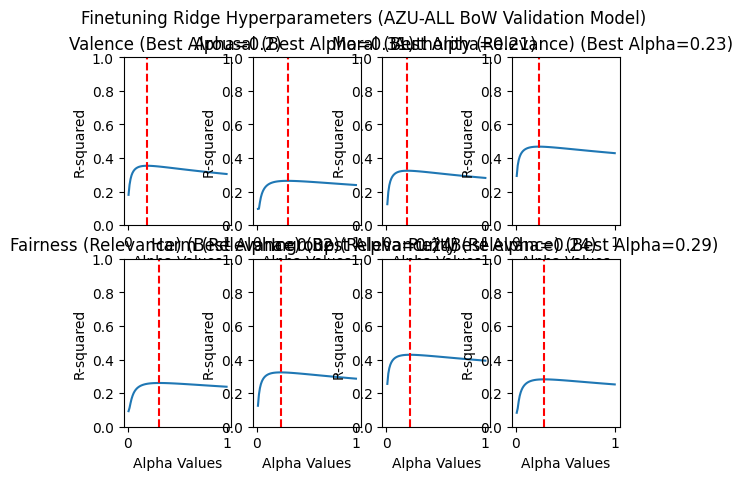

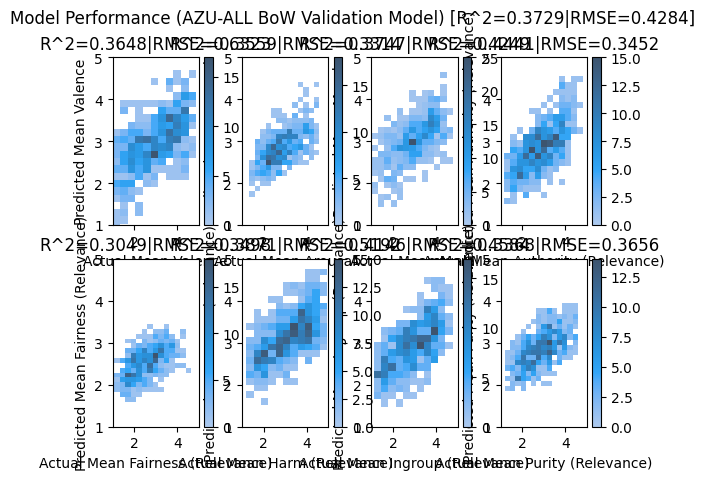

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(Azure_BOW_matrix, Y, test_size=0.2, random_state=365)
folder_name = "Azure-kfold-model-validation"
model_name = "AZU-ALL BoW Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 101, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,1.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

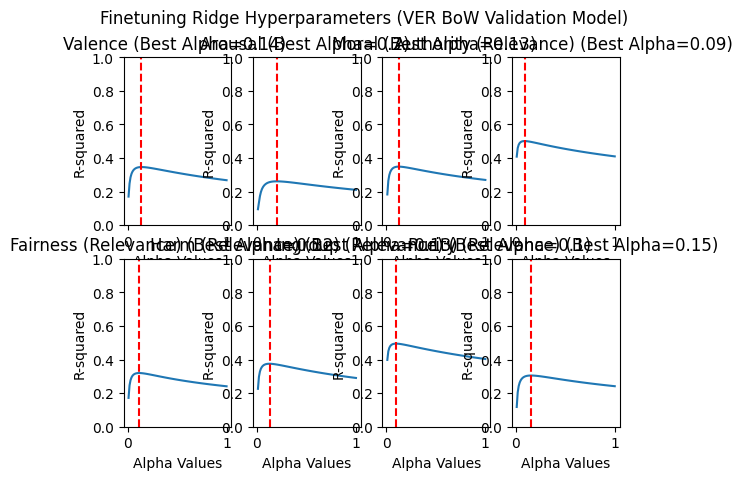

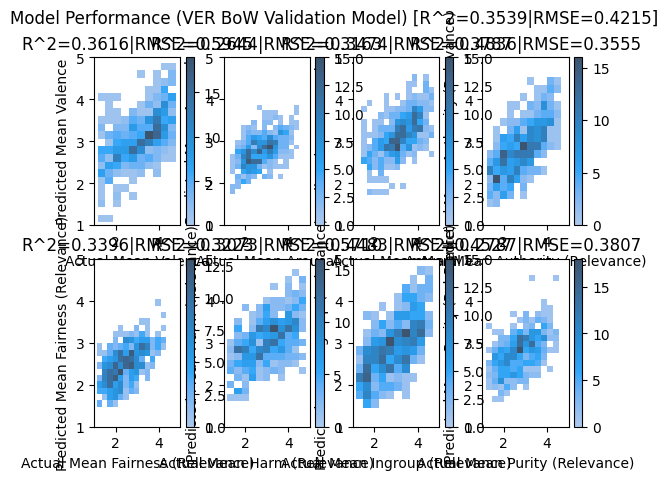

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(Vertex_BOW_matrix, Y[subset_mask], test_size=0.2, random_state=365)
folder_name = "Google-kfold-model-validation"
model_name = "VER BoW Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 101, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,1.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

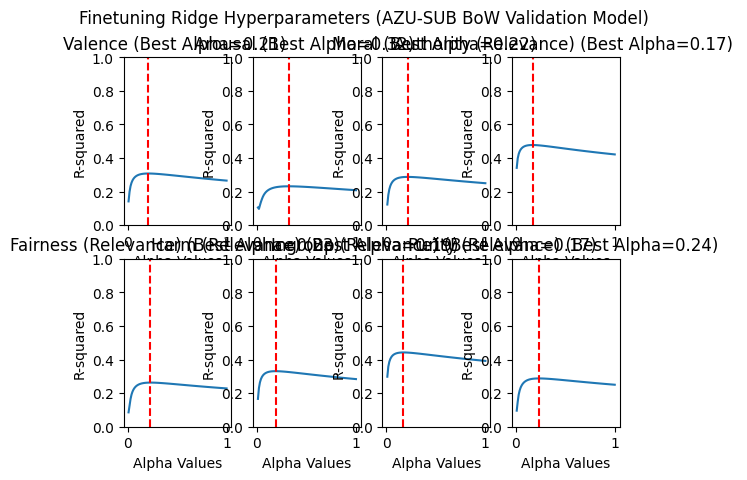

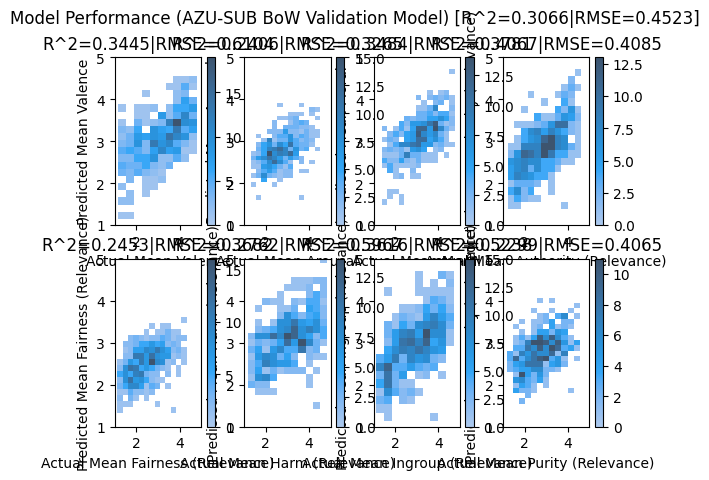

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(Azure_subset_BOW_matrix, Y[subset_mask], test_size=0.2, random_state=365)
folder_name = "Azure-subset-kfold-model-validation"
model_name = "AZU-SUB BoW Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 101, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,1.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

### SBERT

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(SBERT_embed_1, Y, test_size=0.2, random_state=365)
folder_name = "Azure-sBERT-1-kfold-model-validation"
model_name = "AZU-ALL SBERT-1 Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(SBERT_embed_2, Y, test_size=0.2, random_state=365)
folder_name = "Azure-sBERT-2-kfold-model-validation"
model_name = "AZU-ALL SBERT-2 Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(SBERT_embed_3, Y, test_size=0.2, random_state=365)
folder_name = "Azure-sBERT-3-kfold-model-validation"
model_name = "AZU-ALL SBERT-3 Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(SBERT_embed_4, Y, test_size=0.2, random_state=365)
folder_name = "Azure-sBERT-4-kfold-model-validation"
model_name = "AZU-ALL SBERT-4 Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(SBERT_embed_5, Y, test_size=0.2, random_state=365)
folder_name = "Azure-sBERT-5-kfold-model-validation"
model_name = "AZU-ALL SBERT-5 Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(SBERT_embed_6, Y, test_size=0.2, random_state=365)
folder_name = "Azure-sBERT-6-kfold-model-validation"
model_name = "AZU-ALL SBERT-6 Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################
if not os.path.exists("./Cross-Validation-Pickled/{}/".format(folder_name)):
    os.makedirs("./Cross-Validation-Pickled/{}/".format(folder_name))
for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Model Performance ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                      round(np.mean(R2s),4),
                                                                      round(np.mean(RMSEs),4)))
plt.show()

### CLIP

#### Text Only

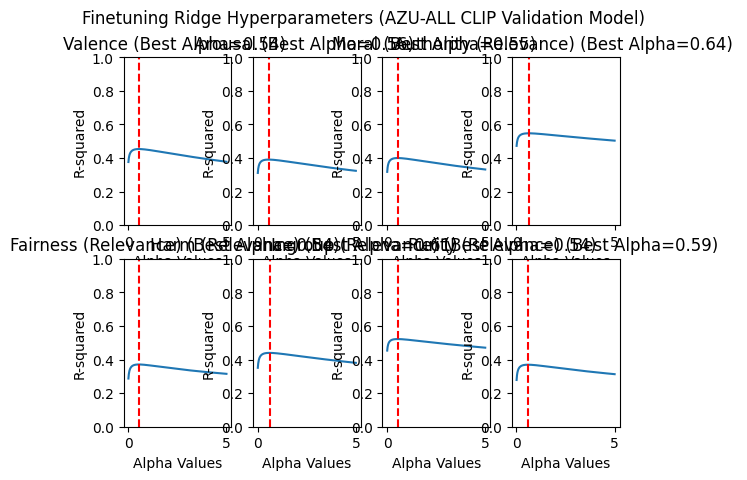

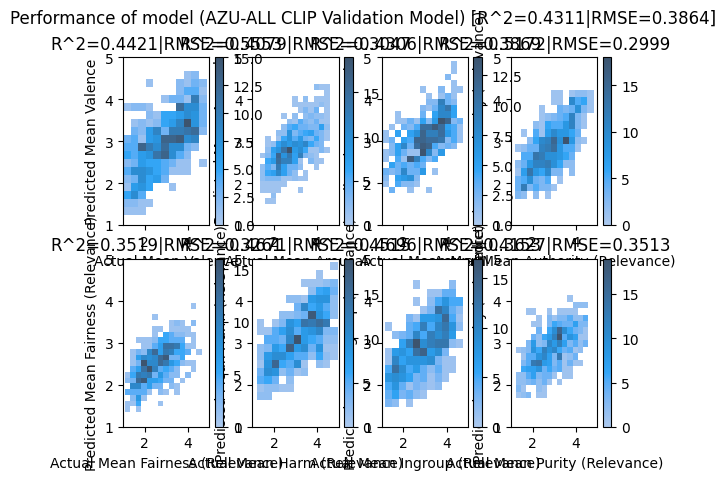

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(ViT_azure_encodings, Y, test_size=0.2, random_state=365)
folder_name = "Azure-CLIP-kfold-model-validation"
model_name = "AZU-ALL CLIP Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

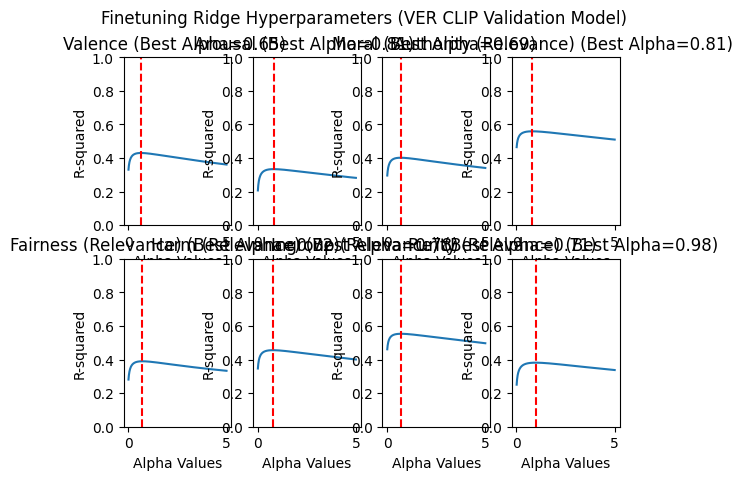

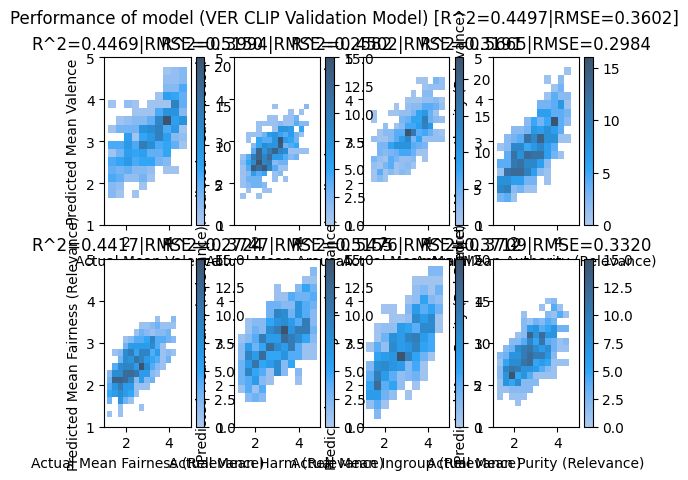

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(ViT_vertex_encodings, Y[subset_mask], test_size=0.2, random_state=365)
folder_name = "Google-CLIP-kfold-model-validation"
model_name = "VER CLIP Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

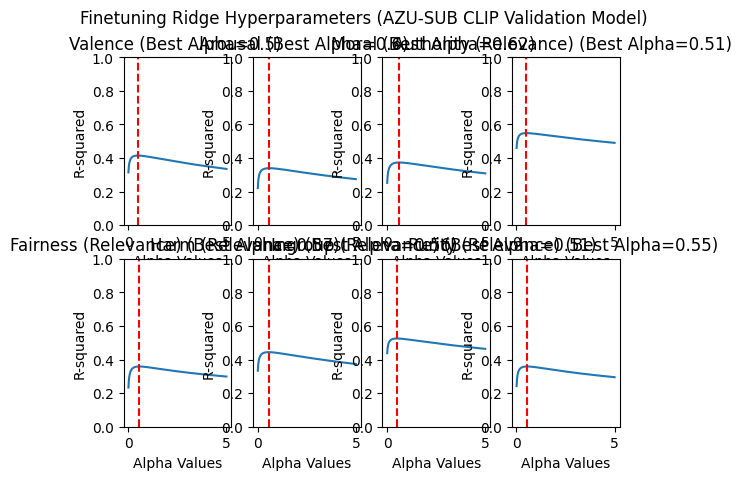

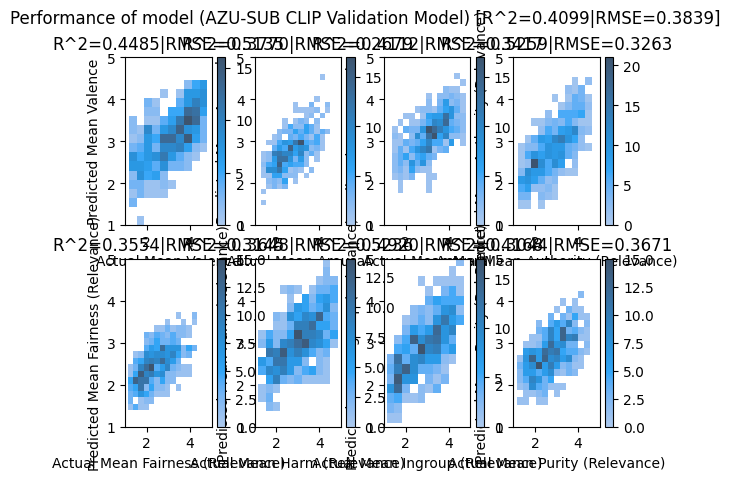

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(ViT_azure_encodings[subset_mask], Y[subset_mask], test_size=0.2, random_state=365)
folder_name = "Azure-subset-CLIP-kfold-model-validation"
model_name = "AZU-SUB CLIP Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

#### Gray-scale Image Only

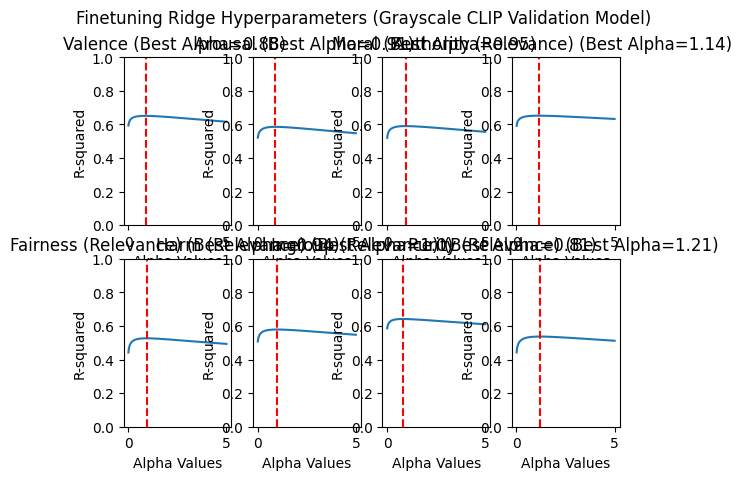

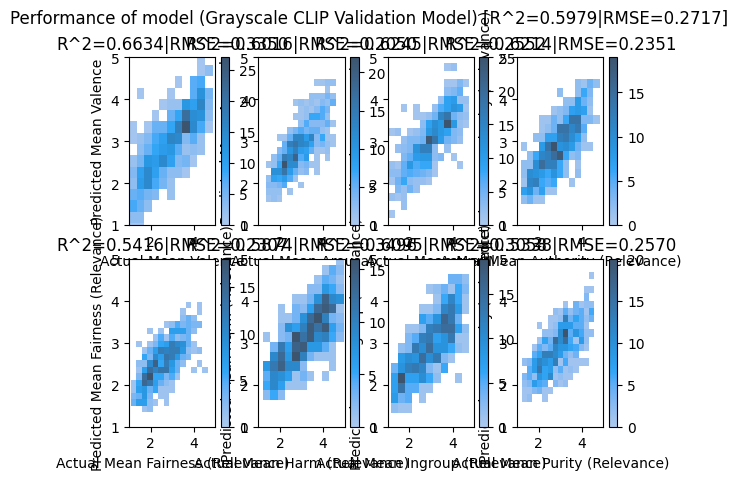

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(ViT_gray_img_encodings, Y, test_size=0.2, random_state=365)
folder_name = "IMG-GRAY-CLIP-kfold-model-validation"
model_name = "Grayscale CLIP Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

#### Colour Image Only

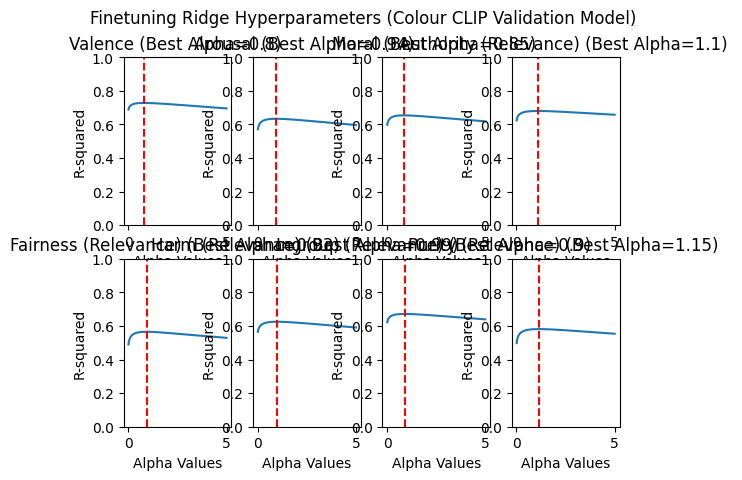

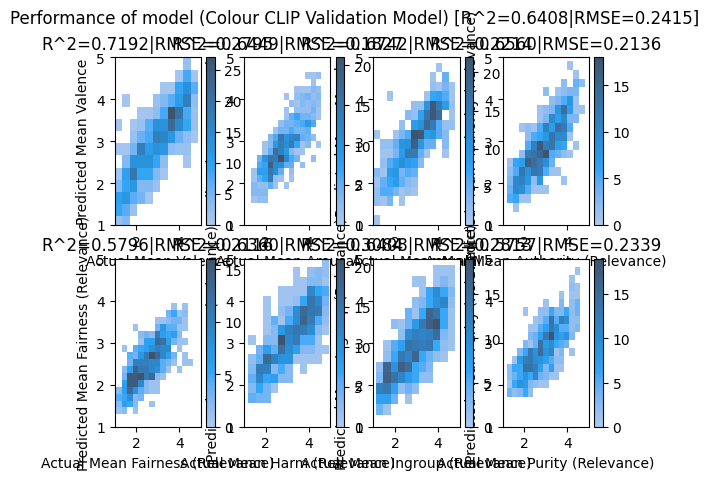

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(ViT_img_encodings, Y, test_size=0.2, random_state=365)
folder_name = "IMG-CLIP-kfold-model-validation"
model_name = "Colour CLIP Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

#### Joint Text-Image

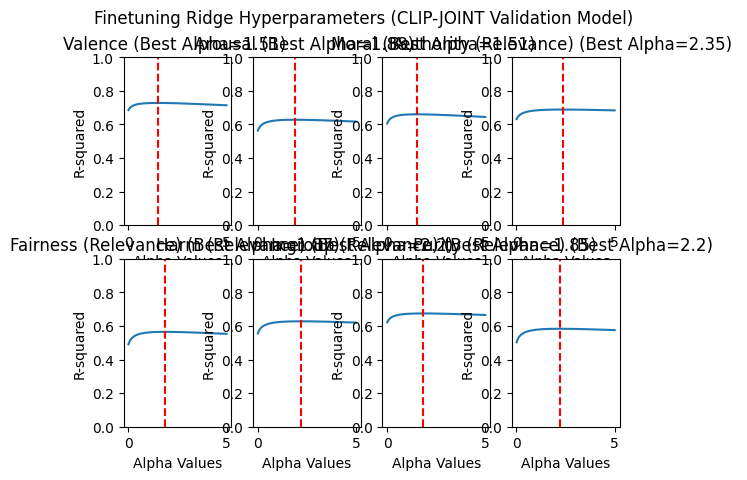

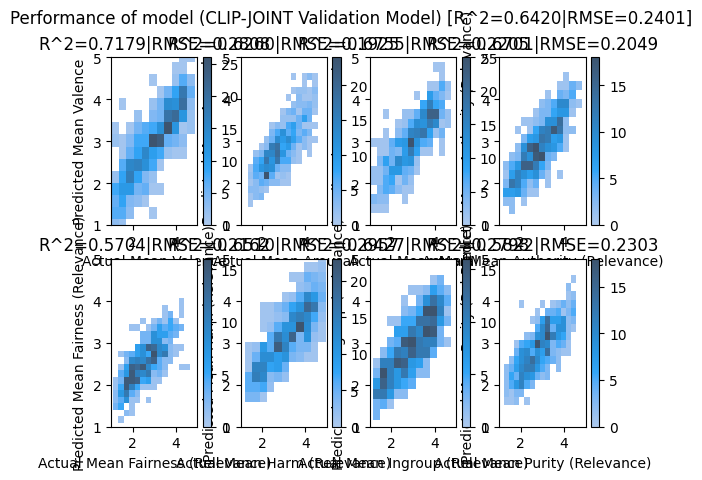

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(ViT_img_encodings+ViT_azure_encodings, Y, test_size=0.2, random_state=365)
folder_name = "JOINT-CLIP-kfold-model-validation"
model_name = "CLIP-JOINT Validation Model"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []

fig, axs = plt.subplots(2, 4)
for i in range(8):
    # Make the model
    regr = Ridge(alpha=best_alphas[i])
    model = regr.fit(X_train, Y_train[:,i])
    predicted_y = model.predict(X_test)
    # Make plot
    sns.histplot(x=Y_test[:, i], y=predicted_y, ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_test[:,i], predicted_y))
    RMSEs.append(mean_squared_error(Y_test[:,i], predicted_y))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

## Training Final Models

The models here are trained on all images found in SMID. Performances of models on SMID are also shown.

Here, only the set of Azure captions are used.

In [85]:
# Make a folder for recording average R^2 values across cross-validation for 
# various hyperparameters and models
#
# This is important during our hyperparameter tuning process
if not os.path.exists("./Finalized-Models/"):
    os.makedirs("./Finalized-Models/")

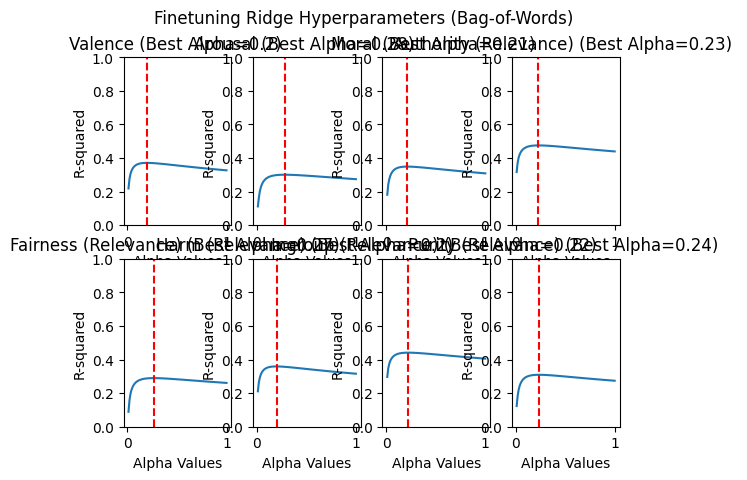

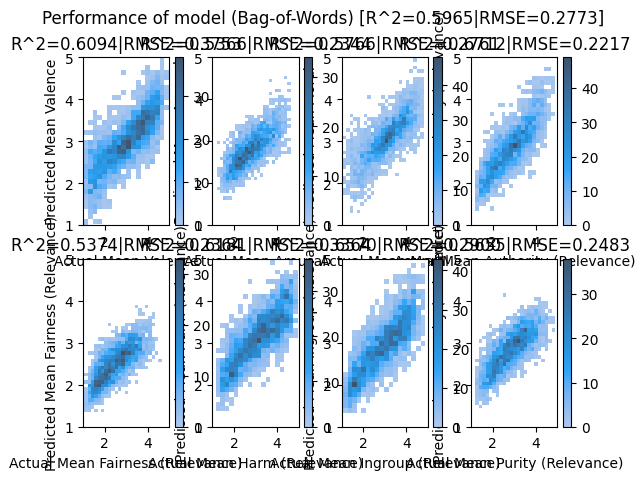

In [90]:
X_train, Y_train = Azure_BOW_matrix, Y
folder_name = "Azure-kfold"
model_name = "Bag-of-Words"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,1.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []
fig, axs = plt.subplots(2, 4)

regr = Ridge(alpha=np.array(best_alphas))
model = regr.fit(X_train, Y_train)
predicted_Y = model.predict(X_train)
for i in range(8):
    # Make plot
    sns.histplot(x=Y_train[:, i], y=predicted_Y[:,i], ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_train[:,i], predicted_Y[:,i]))
    RMSEs.append(mean_squared_error(Y_train[:,i], predicted_Y[:,i]))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

model_path = Path("./Finalized-Models/BOW.pickle")
if not model_path.is_file():
    with open(model_path, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

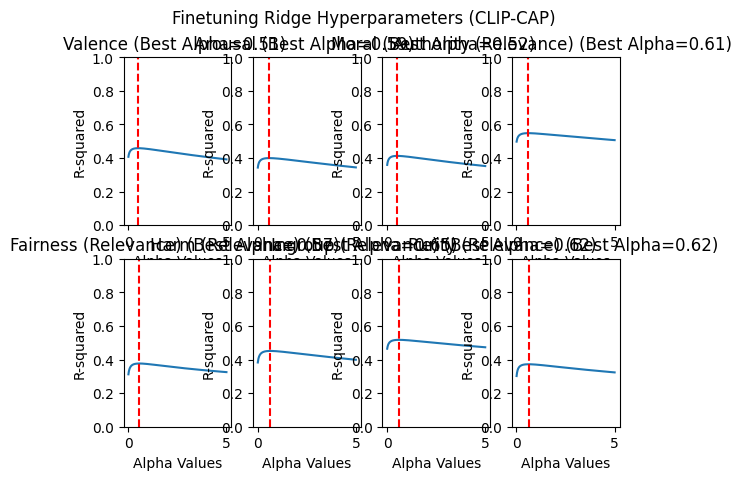

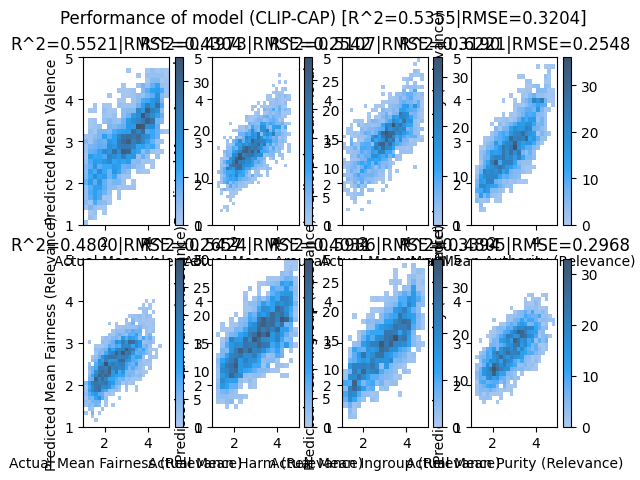

In [83]:
X_train, Y_train = ViT_azure_encodings, Y
folder_name = "Azure-CLIP-kfold"
model_name = "CLIP-CAP"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []
fig, axs = plt.subplots(2, 4)

regr = Ridge(alpha=np.array(best_alphas))
model = regr.fit(X_train, Y_train)
predicted_Y = model.predict(X_train)
for i in range(8):
    # Make plot
    sns.histplot(x=Y_train[:, i], y=predicted_Y[:,i], ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_train[:,i], predicted_Y[:,i]))
    RMSEs.append(mean_squared_error(Y_train[:,i], predicted_Y[:,i]))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

model_path = Path("./Finalized-Models/CLIP-CAP.pickle")
if not model_path.is_file():
    with open(model_path, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

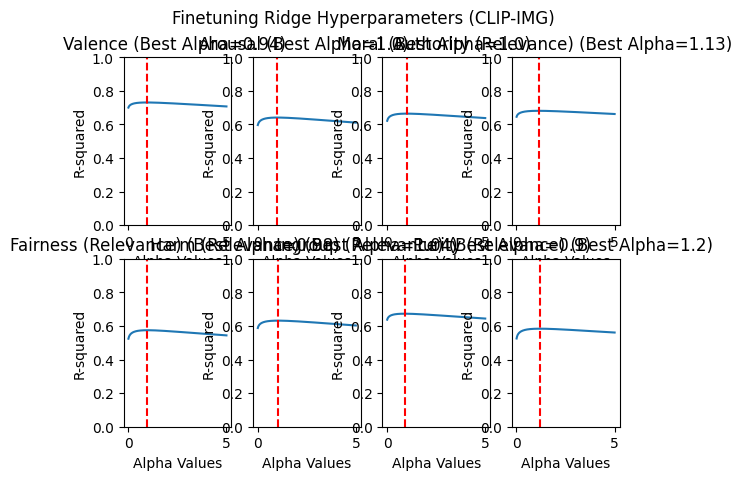

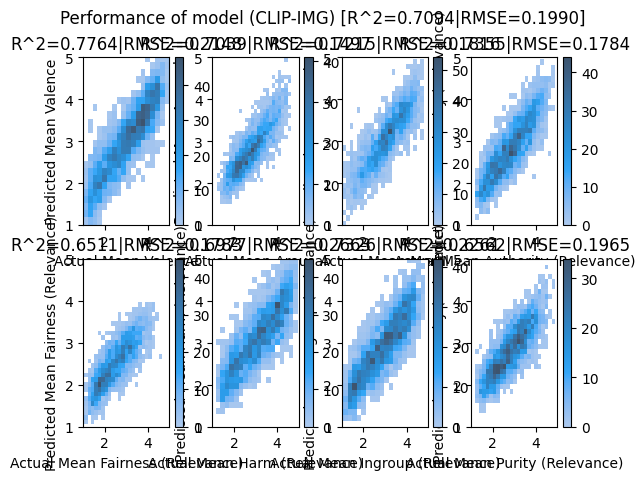

In [82]:
X_train, Y_train = ViT_img_encodings, Y
folder_name = "IMG-CLIP-kfold"
model_name = "CLIP-IMG"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []
fig, axs = plt.subplots(2, 4)

regr = Ridge(alpha=np.array(best_alphas))
model = regr.fit(X_train, Y_train)
predicted_Y = model.predict(X_train)
for i in range(8):
    # Make plot
    sns.histplot(x=Y_train[:, i], y=predicted_Y[:,i], ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_train[:,i], predicted_Y[:,i]))
    RMSEs.append(mean_squared_error(Y_train[:,i], predicted_Y[:,i]))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

model_path = Path("./Finalized-Models/CLIP-IMG.pickle")
if not model_path.is_file():
    with open(model_path, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

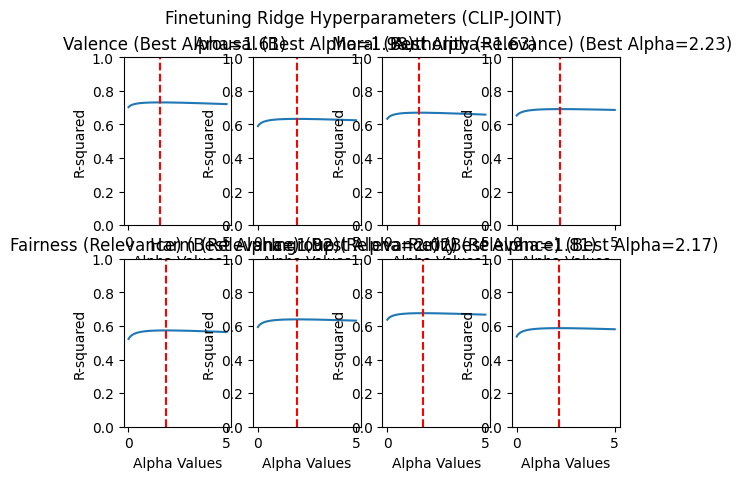

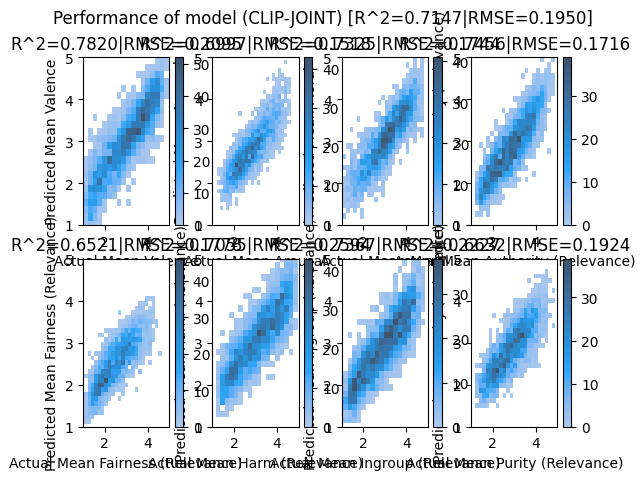

In [81]:
X_train, Y_train = ViT_img_encodings+ViT_azure_encodings, Y
folder_name = "JOINT-CLIP-kfold"
model_name = "CLIP-JOINT"

fig, axs = plt.subplots(2, 4)

plt_names = ["Valence", "Arousal", 
            "Moral", "Authority (Relevance)",
            "Fairness (Relevance)", "Harm (Relevance)",
            "Ingroup (Relevance)", "Purity (Relevance)"]
best_alphas = []


########################
# Hyperparameter tuning
########################

for i in range(8):
    # If we've done cross-validation before, reload the data
    # Otherwise, run and save the data.
    file_name = col_names[i] + ".pickle"
    file_path = Path("./Cross-Validation-Pickled/{}/".format(folder_name)+file_name)
    if file_path.is_file():
        with open(file_path, 'rb') as handle:
            cv_errors = pickle.load(handle)
    else:
        cv_errors = []
        for a in range(1, 501, 1):
            cv_errors.append(kfoldRidgeCV(X_train,Y_train[:,i],10,a/100))
        with open(file_path, 'wb') as handle:
            pickle.dump(cv_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Set up the axes accordingly
    axs[i//4, i%4].plot(np.arange(0.01,5.01,0.01), cv_errors)
    axs[i//4, i%4].set_xlabel('Alpha Values')
    axs[i//4, i%4].set_ylabel('R-squared')
    axs[i//4, i%4].set_ylim([0, 1])

    # Find the best alpha value and add a nice title to each subplot
    best_alpha_index = np.argmax(cv_errors)
    best_alpha = (best_alpha_index+1)/100
    axs[i//4, i%4].axvline(x = best_alpha, color = 'r', ls = '--')
    axs[i//4, i%4].set_title("{} (Best Alpha={}) ".format(plt_names[i], best_alpha))
    best_alphas.append(best_alpha)

fig.suptitle("Finetuning Ridge Hyperparameters ({})".format(model_name))
plt.show()


########################
# Model Performance
########################
R2s =  []
RMSEs = []
fig, axs = plt.subplots(2, 4)

regr = Ridge(alpha=np.array(best_alphas))
model = regr.fit(X_train, Y_train)
predicted_Y = model.predict(X_train)
for i in range(8):
    # Make plot
    sns.histplot(x=Y_train[:, i], y=predicted_Y[:,i], ax=axs[i//4, i%4], vmin=0, cbar=True)
    axs[i//4, i%4].set_xlim(1,5)
    axs[i//4, i%4].set_ylim(1,5)
    axs[i//4, i%4].set_xlabel('Actual Mean ' + plt_names[i])
    axs[i//4, i%4].set_ylabel('Predicted Mean ' + plt_names[i])
    R2s.append(r2_score(Y_train[:,i], predicted_Y[:,i]))
    RMSEs.append(mean_squared_error(Y_train[:,i], predicted_Y[:,i]))
    axs[i//4, i%4].set_title("R^2={:.4f}|RMSE={:.4f}".format(round(R2s[i],4), 
                                                             round(RMSEs[i],4)))

fig.suptitle("Performance of model ({}) [R^2={:.4f}|RMSE={:.4f}]".format(model_name,
                                                                               round(np.mean(R2s),4),
                                                                               round(np.mean(RMSEs),4)))
plt.show()

model_path = Path("./Finalized-Models/CLIP-JOINT.pickle")
if not model_path.is_file():
    with open(model_path, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Summary Tables

Below is some code used to create tables that contain information not captured by the above plots.

### Cross-Validation R^2 averages

The code below was used to create a table in the appendix. A little editing and rendering the output in LaTeX will produce the table.

In [86]:
def cross_valid_r2(model_list, is_RF, X_list, Y_list):
    assert(len(model_list)==len(is_RF))
    assert(len(is_RF)==len(X_list))
    assert(len(is_RF)==len(Y_list))

    file_names = ["valence_mean", "arousal_mean", 
             "moral_mean", "authority_mean",
             "fairness_mean", "harm_mean",
             "ingroup_mean", "purity_mean"]
    row_names = ["Valence", "Arousal", 
                 "Moral", "Authority (R)",
                 "Fairness (R)", "Harm (R)",
                 "Ingroup (R)", "Purity (R)"]
    all_means = []
    all_SE = []
    for model_i in range(len(model_list)):
        model_means = []
        model_SE = []
        X_train, X_test, Y_train, Y_test = train_test_split(X_list[model_i], Y_list[model_i], test_size=0.2, random_state=365)
        for variable_i in range(len(file_names)):
            # Model retrieval
            if is_RF[model_i]:
                file_path = Path("./Random-Forests-Pickled/{}/".format(model_list[model_i])+file_names[variable_i] + ".pickle")
                with open(file_path, 'rb') as handle:
                    model = pickle.load(handle)
            else:
                file_path = Path("./Cross-Validation-Pickled/{}/".format(model_list[model_i])+file_names[variable_i] + ".pickle")
                with open(file_path, 'rb') as handle:
                    cv_errors = pickle.load(handle)
                best_alpha_index = np.argmax(cv_errors)
                best_alpha = (best_alpha_index+1)/100
                regr = Ridge(alpha=best_alpha)
                model = regr.fit(X_train, Y_train[:,variable_i])
            # R2 computation
                cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=365)
                scores = cross_val_score(model, X_train, Y_train[:,variable_i], scoring='r2', cv=cv, n_jobs=-1)
            model_means.append(np.mean(scores))
            model_SE.append(sp.sem(scores))
        all_means.append(model_means)
        all_SE.append(model_SE)
    
    ###################
    # Print the table #
    ###################
    for model_i in range(len(model_list)):
        model_acc = model_list[model_i]
        # Print means
        for var_i in range(2, len(row_names)):
            model_acc += " & "+str(round(all_means[model_i][var_i], 4))
        model_acc += "\\\\"
        print(model_acc)
        # Print SEs
        row_string = ""
        for var_i in range(2, len(row_names)):
            row_string += " & ($\\pm$ {})".format(str(round(all_SE[model_i][var_i], 4)))
        row_string += "\\\\"
        print(row_string)
        print("\hline")

In [ ]:
model_list=["Azure-kfold-model-validation",
            "Azure-sBERT-1-kfold-model-validation",
            "Azure-sBERT-2-kfold-model-validation",
            "Azure-sBERT-3-kfold-model-validation",
            "Azure-sBERT-4-kfold-model-validation",
            "Azure-sBERT-5-kfold-model-validation",
            "Azure-sBERT-6-kfold-model-validation",
            "Azure-CLIP-kfold-model-validation",
            "IMG-GRAY-CLIP-kfold-model-validation",
            "IMG-CLIP-kfold-model-validation",
            "JOINT-CLIP-kfold-model-validation"]
is_RF=[False]*len(model_list)
X_list=[Azure_BOW_matrix, 
        SBERT_embed_1,
        SBERT_embed_2,
        SBERT_embed_3,
        SBERT_embed_4,
        SBERT_embed_5,
        SBERT_embed_6,
        ViT_azure_encodings,
        ViT_gray_img_encodings, 
        ViT_img_encodings,
        ViT_img_encodings+ViT_azure_encodings]
Y_list=[Y]*len(model_list)

cross_valid_r2(model_list, is_RF, X_list, Y_list)

### Most Influential Words

The code chunk below was used to create tables in the appendix. Rendering the output in LaTeX will produce the tables.

In [91]:
def caption_word_search(word, captions=Vertex_captions, BOW=Vertex_BOW):
    all_captions_containing = []
    for i in range(len(captions)):
        if BOW[i][word]>0:
            all_captions_containing.append(captions[i])
    return all_captions_containing

In [101]:
plt_names = ["Valence", "Arousal", 
             "Moral", "Authority (Relevance)",
             "Fairness (Relevance)", "Harm (Relevance)",
             "Ingroup (Relevance)", "Purity (Relevance)"]


file_path = ".\Finalized-Models\BOW.pickle"
with open(file_path, 'rb') as handle:
    model = pickle.load(handle)

for i in range(8):
    ### Printing words with highest coefficients
    print("\\begin{center}")
    print("{"+"\\bf Top 30 most influential words ({})".format(plt_names[i])+"}")
    print("\\begin{tabular}{||c c c c||} ")
    print("\\hline")
    print("Word & Coefficient & Count & Example Sentence \\\\ [0.5ex] ")
    print("\\hline\\hline")

    coeffs = model.coef_[i]
    if i<3:
        sorted = np.argsort(abs(coeffs)) # Valence, Arousal, and Morality--words can be strongly positive or negative.
    else:
        sorted = np.argsort(coeffs) # Relevance should be absolute--we don't care about irrelevant words

    ender=""
    k=-1
    while k>=-30:
        if k==-30:
            ender="[1ex]"
        w=Azure_index_to_word(sorted[k])
        # Print
        print("{} & {} & {} & {} \\\\ {}".format(w, round(coeffs[sorted[k]],4), 
                                                 Vertex_total_BOW[w], 
                                                 caption_word_search(w,captions=Azure_captions, BOW=Azure_BOW)[0][0], 
                                                 ender))
        print("\\hline")
        # Increment
        k-=1
    
    print("\\end{tabular}")
    print("\\end{center}")
    print("")
    print("\\newpage")
    print("")

\begin{center}
{\bf Top 30 most influential words (Valence)}
\begin{tabular}{||c c c c||} 
\hline
Word & Coefficient & Count & Example Sentence \\ [0.5ex] 
\hline\hline
destroyed & -4.2916 & 0 & a \\ 
\hline
fire & -3.2128 & 17 & a \\ 
\hline
dirty & -3.2 & 3 & a \\ 
\hline
handcuffs & -3.1104 & 4 & a \\ 
\hline
garbage & -3.0742 & 6 & a \\ 
\hline
laughing & 3.0482 & 6 & a \\ 
\hline
explosion & -3.0321 & 0 & a \\ 
\hline
hugging & 2.8134 & 20 & a \\ 
\hline
cage & -2.7804 & 16 & a \\ 
\hline
crashed & -2.6849 & 1 & a \\ 
\hline
guns & -2.6786 & 0 & a \\ 
\hline
traditional & 2.6763 & 7 & a \\ 
\hline
calf & 2.6287 & 0 & a \\ 
\hline
landfill & -2.6246 & 0 & a \\ 
\hline
squirrel & 2.6103 & 3 & a \\ 
\hline
gun & -2.6014 & 0 & a \\ 
\hline
cigarette & -2.6008 & 0 & a \\ 
\hline
metal & -2.5701 & 6 & a \\ 
\hline
cut & -2.5269 & 2 & a \\ 
\hline
heart & 2.509 & 6 & a \\ 
\hline
dog & 2.5073 & 105 & a \\ 
\hline
crying & -2.5001 & 8 & a \\ 
\hline
cans & 2.4708 & 3 & a \\ 
\hline
giving